## Feature selection of pyradiomic feutures
 #### As refered in article 2, the most common algorithms for feature selection are:
     
     - Random Forest
     - PCA(principle component analysis)
     - LASSO(least absolute shrinkage and selection operator) 
     
We'll be using all 3 and choosing the one that has the best results in several metrics.


### Imports needed 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from pyswarm import pso
from sklearn.metrics import roc_auc_score, roc_curve

## Data preparation

#### Dataset loading and class normalization

As indicated by the professor, it is important to normalize the classes because, if normalization is not performed, the model may unintentionally favor one class over another. Therefore, we decided to normalize all columns to a range between 0 and 1.

For the malignancy class, we classified cases where the malignancy score was 1 or 2 as benign, and scores of 4 or 5 as malignant. We excluded all elements with a malignancy score of 3, as they do not fit well into a binary classification model.

In [2]:
dataset_path = r'Feature Extraction and Data Cleaning\radiomic_features_pylidc_and_fourier_per_annotation.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(dataset_path)
# Get the shape of the dataset (rows, columns)
print(df.shape)

# Get basic statistics about the dataset
print(df.describe())

# Classifying the malignancy
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})  # 0 = benign, 1 = malignant
df = df[df['malignancy'] != 3]  # Removing rows with malignancy 3

# Drop Non-Numeric Columns
df_numeric = df.select_dtypes(include=[float, int])

# Separate Features and Target
X = df_numeric.drop('malignancy', axis=1)  # Features
y = df_numeric['malignancy']  # Target

# Normalize Features Between 0 and 1
scaler = MinMaxScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Create a New DataFrame
processed_df = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)



(6859, 153)
       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                      6859.000000                         6859.000000   
mean                       -540.352213                         -949.656655   
std                         158.899785                           71.932389   
min                        -895.726852                        -1403.000000   
25%                        -656.677452                        -1018.000000   
50%                        -554.944444                         -960.000000   
75%                        -442.556090                         -903.000000   
max                         359.254545                         -263.000000   

       diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
count                         6859.000000                         6859.000000   
mean                           318.691209                          867.871410   
std                            572.672501 

Due to the imbalance between the malignant and benign classes, and following the professor's recommendation, we decided to apply techniques to balance the classes. In the provided documents, we didn't find references to either undersampling or oversampling, so we visited https://imbalanced-learn.org/ to explore different techniques.

We discovered that common oversampling techniques include SMOTE, which generates new samples by interpolating existing ones, and ADASYN, which also generates new samples but focuses more on misclassified minority class samples. We decided to apply both techniques to compare their effectiveness.

As for undersampling, we chose not to use it because it would involve removing a large portion of the benign class samples. Instead, we opted for a hybrid approach, selecting SMOTETomek, which combines both oversampling and undersampling. Between SMOTEENN and SMOTETomek, we chose the latter because it is less aggressive in removing samples while still cleaning the dataset of noisy data. Compared to pure undersampling techniques, SMOTETomek retains more samples, making it a better fit for our data.

#### SMOTE

In [3]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled_, y_train_resampled = smote.fit_resample(X_train, y_train)

# X_train_resampled and y_train_resampled are your balanced training sets

#### ADASYN

In [14]:
adasyn = ADASYN(random_state=42)
X_train_resampled_adasyn, y_train_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

#### SMOTETomek

In [5]:
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled_smote_tomek, y_train_resampled_smote_tomek = smote_tomek.fit_resample(X_train, y_train)


## Feature selection

### Random forest

In [15]:
# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2,random_state=42)

rf.fit(X_train, y_train)

# Make predictions and calculate accuracy before feature selection
y_pred = rf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(initial_accuracy)


0.8871915393654524


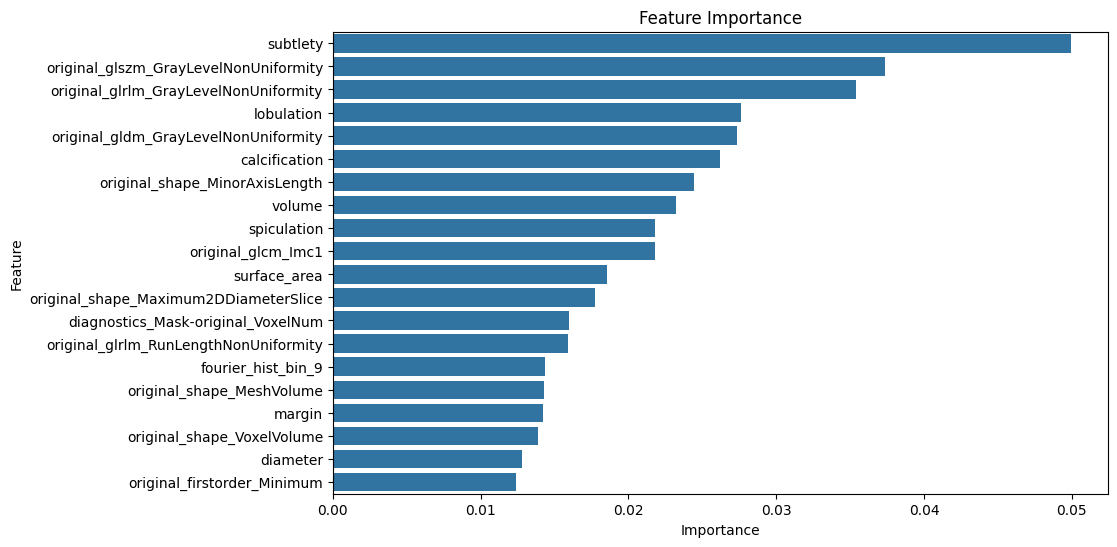

In [16]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df_small = feature_importance_df.head(20)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_small)
plt.title('Feature Importance')
plt.show()


In [17]:
# Select top 5 features (as an example)
top_features = feature_importance_df.head(40)['Feature'].values

# Create a new dataset with only the top features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


# Train the classifier with selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Make predictions and calculate accuracy after feature selection
y_pred_selected = rf_selected.predict(X_test_selected)
selected_accuracy = accuracy_score(y_test, y_pred_selected)

print(f'Accuracy before feature selection: {initial_accuracy:.4f}')
print(f'Accuracy after feature selection: {selected_accuracy:.4f}')


Accuracy before feature selection: 0.8872
Accuracy after feature selection: 0.8989


### LASSO

In [9]:
# Convert the continuous target into binary labels (benign/malignant)
threshold = 0.5  # Assuming values >= 0.5 are malignant
y_binary = np.where(y >= threshold, 1, 0)  # 1 for malignant, 0 for benign

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2,random_state=42)


# Standardize the features (important for LASSO)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model with L1 (LASSO) regularization
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
lasso.fit(X_train_scaled, y_train)

# Get the coefficients
coefficients = lasso.coef_

# Find the indices of the non-zero coefficients
non_zero_features = np.where(coefficients != 0)[1]
non_zero_features = np.unique(non_zero_features)
# Print the selected features
print("Selected features:", non_zero_features)

# You can map back these indices to the original feature names if needed
selected_feature_names = X.columns[non_zero_features]
print("Selected feature names:", selected_feature_names)

Selected features: [  0   1   2   4   5   6   8  11  12  13  14  15  16  17  18  20  21  22
  23  24  26  29  30  32  33  34  35  39  40  46  47  48  49  50  51  54
  56  57  59  61  63  64  65  69  70  71  73  80  83  84  92  95  97  98
 101 103 106 107 108 109 111 112 113 114 115 116 117 118 119 120 121 122
 123 125 126 127 128 129 130 131]
Selected feature names: Index(['diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_VolumeNum', 'original_shape_Elongation',
       'original_shape_Flatness', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_90Percentile',
       'original_firstorde

### PCA

In [10]:



# Example: Replace 'X' with your dataset and 'y' with your target
# X should be a DataFrame or NumPy array of features

# Step 1: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2,random_state=42)

# Step 2: Apply PCA on the training set
def apply_pca(X_train, X_test, n_components):
    """
    Applies PCA to the training dataset and transforms both the training and test sets.

    Parameters:
    X_train (pd.DataFrame or np.array): The training dataset.
    X_test (pd.DataFrame or np.array): The test dataset.
    n_components (int): The number of principal components to keep.
    
    Returns:
    X_train_pca (np.array): The training set transformed into the selected principal components.
    X_test_pca (np.array): The test set transformed into the selected principal components.
    explained_variance (list): The variance explained by the selected components.
    pca_components (pd.DataFrame): The PCA components for feature importance analysis.
    """

    # Apply PCA only on the training set
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)  # Fit on training data and transform it

    # Transform the test set using the same PCA transformation
    X_test_pca = pca.transform(X_test)

    # Create a DataFrame with PCA components for analysis
    pca_components = pd.DataFrame(pca.components_, columns=X_train.columns)

    # Variance explained by each component
    explained_variance = pca.explained_variance_ratio_

    return X_train_pca, X_test_pca, explained_variance, pca_components

# Step 3: Call the PCA function with a fixed number of components
n_components = 2  # Specify the number of components you want to keep
X_train_pca, X_test_pca, explained_variance, pca_components = apply_pca(X_train, X_test, n_components=n_components)

# Step 4: Output the explained variance for each component
print("Explained Variance by Components:")
print(explained_variance)

# Step 5: Output the principal components for feature analysis
print("PCA Components (Feature Weights):")
print(pca_components)



Explained Variance by Components:
[0.34020877 0.21671409]
PCA Components (Feature Weights):
   diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
0                         0.065981                           -0.009962   
1                         0.058486                           -0.031038   

   diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
0                            0.142551                           -0.018074   
1                            0.123971                            0.045771   

   diagnostics_Mask-original_VolumeNum  original_shape_Elongation  \
0                            -0.002052                   0.035436   
1                             0.004526                   0.011524   

   original_shape_Flatness  original_shape_LeastAxisLength  \
0                 0.040640                       -0.026083   
1                 0.021661                        0.093930   

   original_shape_MajorAxisLength  original_shape_Maximum2

## Classifiction models

### Logistic regression

In [18]:
# Train Logistic Regression model
'''log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_selected, y_train)

# Make predictions and evaluate Logistic Regression
y_pred_log_reg = log_reg.predict(X_test_selected)
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression Accuracy: {log_reg_accuracy:.4f}')
print(f'Logistic Regression Classification Report:\n{classification_report(y_test, y_pred_log_reg)}')'''

# Garantir que as mesmas variáveis selecionadas são usadas para treino e teste
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Treinar o modelo de Regressão Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_selected, y_train)

# Fazer predições e avaliar
y_pred_log_reg = log_reg.predict(X_test_selected)
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression Accuracy: {log_reg_accuracy:.4f}')
print(f'Logistic Regression Classification Report:\n{classification_report(y_test, y_pred_log_reg)}')


Logistic Regression Accuracy: 0.8684
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       506
           1       0.79      0.93      0.85       345

    accuracy                           0.87       851
   macro avg       0.86      0.88      0.87       851
weighted avg       0.88      0.87      0.87       851



Logistic Regression AUC: 0.9523


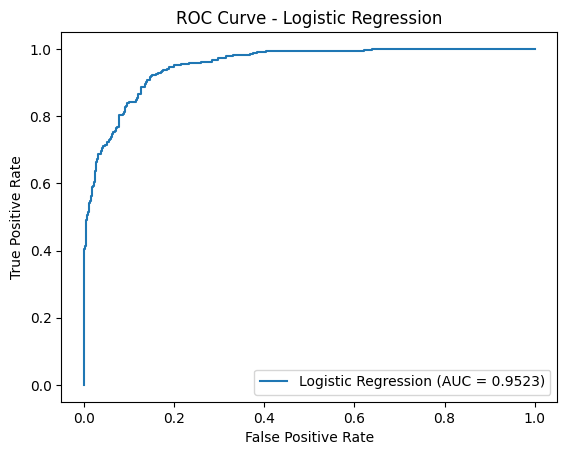

In [19]:
# Predição de probabilidades para calcular a curva ROC
y_pred_log_reg_proba = log_reg.predict_proba(X_test_selected)[:, 1]

# Calcular AUC-ROC
log_reg_auc = roc_auc_score(y_test, y_pred_log_reg_proba)
print(f'Logistic Regression AUC: {log_reg_auc:.4f}')

# Plotar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_log_reg_proba)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()


### Random forest

In [21]:
# Train Random Forest Classifier model 
'''rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Make predictions and evaluate Random Forest
y_pred_rf = rf_selected.predict(X_test_selected)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')
print(f'Random Forest Classification Report:\n{classification_report(y_test, y_pred_rf)}')'''

# Selecionando as 10 variáveis mais importantes (pode ajustar este valor conforme necessário)
top_features = feature_importance_df.head(10)['Feature'].values

# Criar um novo dataset com apenas as top features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Treinar o modelo Random Forest com as variáveis selecionadas
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Fazer predições e avaliar o desempenho
y_pred_rf = rf_selected.predict(X_test_selected)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')
print(f'Random Forest Classification Report:\n{classification_report(y_test, y_pred_rf)}')


Random Forest Accuracy: 0.8813
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       506
           1       0.83      0.89      0.86       345

    accuracy                           0.88       851
   macro avg       0.88      0.88      0.88       851
weighted avg       0.88      0.88      0.88       851



Random Forest AUC: 0.9490


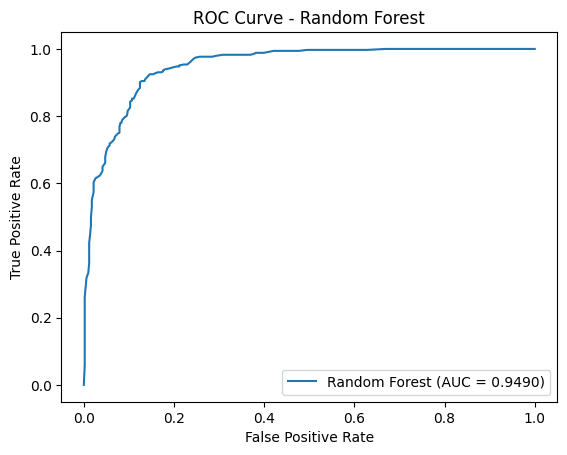

In [22]:
# Predição de probabilidades para calcular a curva ROC
y_pred_rf_proba = rf_selected.predict_proba(X_test_selected)[:, 1]

# Calcular AUC-ROC
rf_auc = roc_auc_score(y_test, y_pred_rf_proba)
print(f'Random Forest AUC: {rf_auc:.4f}')

# Plotar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_proba)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rf_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()


### SVM

In [12]:
# Train SVM model
'''svm_model = SVC(kernel='linear', random_state=42) --> este demorou imenso a rodar nao cheguei a ver resultados
svm_model.fit(X_train_selected, y_train)

# Make predictions and evaluate SVM
y_pred_svm = svm_model.predict(X_test_selected)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {svm_accuracy:.4f}')
print(f'SVM Classification Report:\n{classification_report(y_test, y_pred_svm)}')'''

# Garantir que as mesmas variáveis selecionadas são usadas para treino e teste
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Treinar o modelo SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_selected, y_train)

# Fazer predições e avaliar
y_pred_svm = svm_model.predict(X_test_selected)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {svm_accuracy:.4f}')
print(f'SVM Classification Report:\n{classification_report(y_test, y_pred_svm)}')


SVM Accuracy: 0.8461
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       506
           1       0.82      0.79      0.81       345

    accuracy                           0.85       851
   macro avg       0.84      0.84      0.84       851
weighted avg       0.85      0.85      0.85       851



SVM AUC: 0.9293


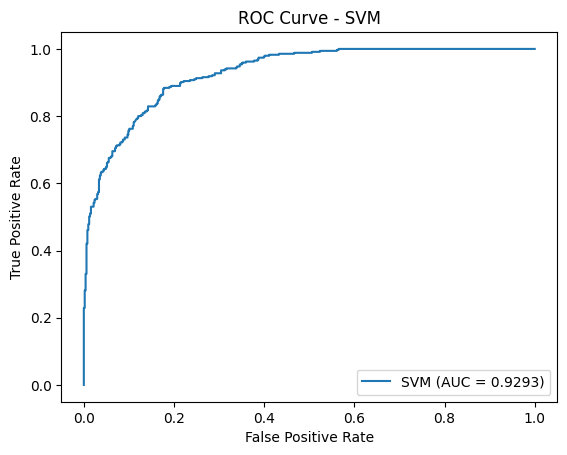

In [13]:
# Recriar o modelo SVM com probabilidade habilitada
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_selected, y_train)

# Predição de probabilidades para calcular a curva ROC
y_pred_svm_proba = svm_model.predict_proba(X_test_selected)[:, 1]

# Calcular AUC-ROC
svm_auc = roc_auc_score(y_test, y_pred_svm_proba)
print(f'SVM AUC: {svm_auc:.4f}')

# Plotar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm_proba)
plt.plot(fpr, tpr, label=f'SVM (AUC = {svm_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.show()


In [ ]:
def svm_pso_objective(params, X_train, y_train, X_val, y_val):
    C, gamma = params  # Parâmetros que o PSO vai otimizar
    model = SVC(C=C, gamma=gamma, kernel='rbf', probability=True, random_state=42)
    
    # Treinar o modelo com os parâmetros atuais
    model.fit(X_train, y_train)
    
    # Prever probabilidades na validação
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calcular AUC (maior é melhor)
    auc = roc_auc_score(y_val, y_pred_proba)
    
    # Retornar 1 - AUC (para minimizar)
    return 1 - auc

# Definir os limites para os hiperparâmetros C e gamma
lb = [0.1, 0.0001]  # Limites inferiores para C e gamma
ub = [1000, 1]      # Limites superiores para C e gamma

# Dividir os dados em treino e validação
X_train_pso, X_val_pso, y_train_pso, y_val_pso = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)

# Aplicar PSO para encontrar os melhores parâmetros de SVM
optimal_params, fopt = pso(svm_pso_objective, lb, ub, args=(X_train_pso, y_train_pso, X_val_pso, y_val_pso), swarmsize=30, maxiter=20)

# Imprimir os melhores parâmetros
print(f'Best C: {optimal_params[0]}')
print(f'Best gamma: {optimal_params[1]}')

SVM with PSO AUC: 0.7646


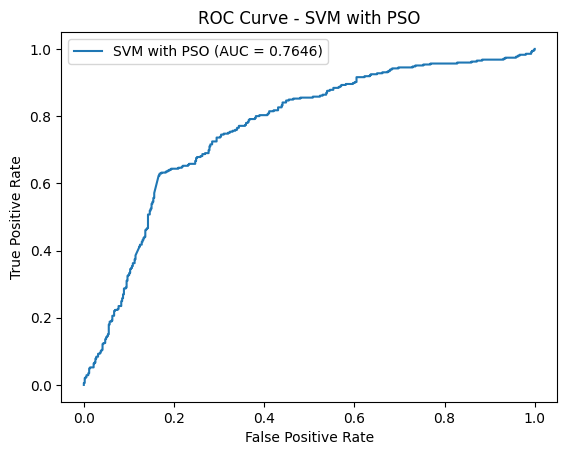

In [24]:
# Treinar o modelo SVM com os parâmetros otimizados
svm_pso_model = SVC(C=optimal_params[0], gamma=optimal_params[1], kernel='rbf', probability=True, random_state=42)
svm_pso_model.fit(X_train_selected, y_train)

# Prever probabilidades no conjunto de teste
y_pred_svm_pso = svm_pso_model.predict_proba(X_test_selected)[:, 1]

# Calcular AUC-ROC no conjunto de teste
svm_pso_auc = roc_auc_score(y_test, y_pred_svm_pso)
print(f'SVM with PSO AUC: {svm_pso_auc:.4f}')

# Plotar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm_pso)
plt.plot(fpr, tpr, label=f'SVM with PSO (AUC = {svm_pso_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM with PSO')
plt.legend()
plt.show()


## 3 Performance comparation